<a href="https://colab.research.google.com/github/SainRigo/mobilenet_plum/blob/main/Copy_of_Mobilenet_plumdatraset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os


# we access the file where are store our images

print(os.listdir("/content/drive/MyDrive/plum_data/plum_data/"))

['Good', 'Bad']


In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, AveragePooling2D
from tensorflow.keras.layers import Concatenate , Flatten , Dense , Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet121 , VGG16
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import normalize
from tensorflow.keras.optimizers import Adam

In [ ]:


defective_path_l = os.listdir('/content/drive/MyDrive/plum_data/plum_data/Bad/')
good_path_l = os.listdir('/content/drive/MyDrive/plum_data/plum_data/Good/')
len(defective_path_l)+ len(good_path_l)

4507

In [ ]:
Image_data = []        # in this list will be append all the images read
Labels_image = []      # in this list will be append the label (statu) in the same oder of each image


# here is the path to the infected images.
# we used a for loop with a step 2 to just read half of the images.

defective_path = "/content/drive/MyDrive/plum_data/plum_data/Bad/"
defective_path_l.sort()

for i in range(0, len(defective_path_l), 2):
    image_path = os.path.join(defective_path, defective_path_l[i])
    images_pil = cv2.imread(image_path)
    image_array = Image.fromarray(images_pil , 'RGB')                     # read of image as RGB
    resize_img = image_array.resize((224 , 224))                          # resizing of image
    Image_data.append(np.array(resize_img))
    Labels_image.append(1)                                                # label on the image


# here we look for the total number of images read and the number of labels in our list
len(Image_data), len(Labels_image)

(1877, 1877)

In [ ]:
good_path = "/content/drive/MyDrive/plum_data/plum_data/Good/"
good_path_l.sort()

for j in range(0, len(good_path_l), 2):
    image_pathu = os.path.join(good_path, good_path_l[j])
    images_pilu = cv2.imread(image_pathu)
    image_arrayu = Image.fromarray(images_pilu, 'RGB')
    resize_imgu = image_arrayu.resize((224 , 224))
    Image_data.append(np.array(resize_imgu))
    Labels_image.append(0)

# we labeled the uninfected cells as 0


# here is the total images for the study, whych is exactly of the half of the total images
len(Image_data), len(Labels_image)

(2254, 2254)

In [ ]:
cells = np.array(Image_data)
labels = np.array(Labels_image)

In [ ]:
print('Shape of Cells : {} , shape of labels : {}'.format(cells.shape , labels.shape))

Shape of Cells : (2254, 224, 224, 3) , shape of labels : (2254,)


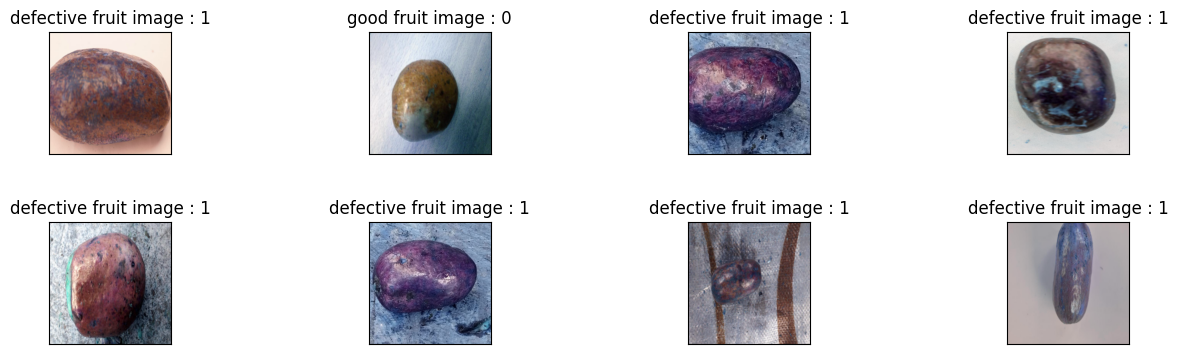

In [ ]:
plt.figure(1 , figsize = (15 , 9))
n = 0
for i in range(8):
    n += 1
    r = np.random.randint(0 , cells.shape[0] , 1)
    plt.subplot(4 , 4 , n)
    plt.subplots_adjust(hspace = 0.56, wspace = 0.56)
    plt.imshow(cells[r[0]])
    plt.title('{} : {}'.format('defective fruit image' if labels[r[0]] == 1 else 'good fruit image' ,
                               labels[r[0]]) )
    plt.xticks([]) , plt.yticks([])

plt.show()

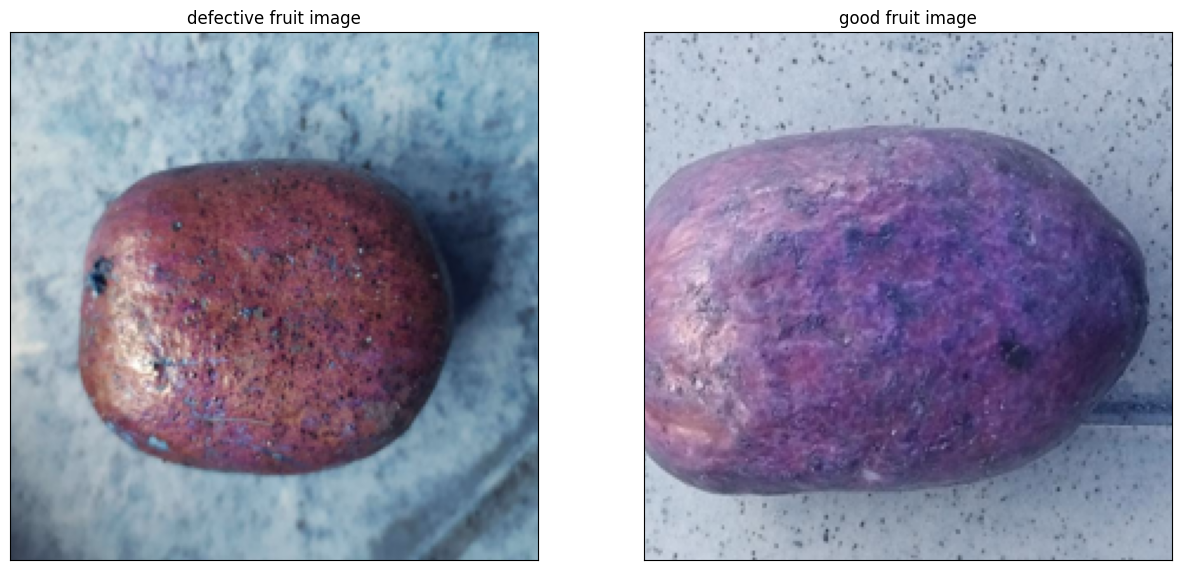

In [ ]:
plt.figure(1, figsize = (15 , 7))
plt.subplot(1 , 2 , 1)
plt.imshow(cells[0])
plt.title('defective fruit image')
plt.xticks([]) , plt.yticks([])

plt.subplot(1 , 2 , 2)
plt.imshow(cells[1800])
plt.title('good fruit image')
plt.xticks([]) , plt.yticks([])

plt.show()

In [ ]:

n = np.arange(cells.shape[0])
np.random.shuffle(n)
cells = cells[n]
labels = labels[n]

In [ ]:
cells = cells.astype(np.float32)/255.00
labels = labels.astype(np.int32)

In [ ]:
# we split the data into train, test and validation set

from sklearn.model_selection import train_test_split

train_x , X , train_y , Y = train_test_split(cells , labels, test_size = 0.3 , random_state = 111)

test_x, valid_x, test_y, valid_y = train_test_split(X,Y, test_size = 0.5, random_state= 111)

In [ ]:
print('Proportion of the data:')
print("train set: X_train: {}, Y_train: {}".format(train_x.shape, train_y.shape))
print('%===============================================%')
print('Validation set: x_validation: {}, y_validation: {}'.format(valid_x.shape, valid_y.shape))
print('%===============================================%')
print("test shape: x_test: {}, y_test: {}".format(test_x.shape, test_y.shape))

Proportion of the data:
train set: X_train: (1577, 224, 224, 3), Y_train: (1577,)
%===============================================%
Validation set: x_validation: (339, 224, 224, 3), y_validation: (339,)
%===============================================%
test shape: x_test: (338, 224, 224, 3), y_test: (338,)


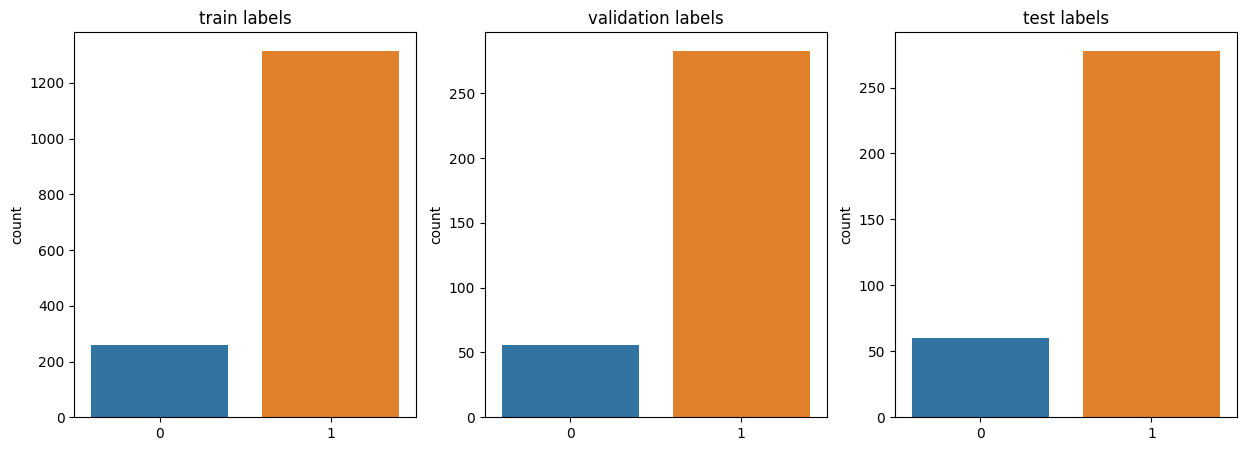

In [ ]:
plt.figure(1 , figsize = (15 ,5))
n = 0
for z , j in zip([train_y , valid_y,  test_y] , ['train labels','validation labels', 'test labels']):
    n += 1
    plt.subplot(1 , 3  , n)
    sns.countplot(x = z )
    plt.title(j)
plt.show()

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *


def mobilenet(input_shape, n_classes):

  def mobilenet_block(x, f, s=1):
    x = DepthwiseConv2D(3, strides=s, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(f, 1, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x


  input = Input(input_shape)

  x = Conv2D(32, 3, strides=2, padding='same')(input)
  x = BatchNormalization()(x)
  x = ReLU()(x)

  x = mobilenet_block(x, 64)
  x = mobilenet_block(x, 128, 2)
  x = mobilenet_block(x, 128)

  x = mobilenet_block(x, 256, 2)
  x = mobilenet_block(x, 256)

  x = mobilenet_block(x, 512, 2)
  for _ in range(5):
    x = mobilenet_block(x, 512)

  x = mobilenet_block(x, 1024, 2)
  x = mobilenet_block(x, 1024)

  x = GlobalAvgPool2D()(x)

  output = Dense(n_classes, activation='softmax')(x)

  model = Model(input, output)
  return model

n_classes = 2  # Replace with the actual number of classes in your classification problem

# Create the model instance using the resnet function
input_shape=(224, 224, 3)
model = mobilenet(input_shape, n_classes)

# Compile the model
model.compile(loss=BinaryCrossentropy(),
              optimizer=Adam(learning_rate=0.01),
              metrics=['accuracy'])

model.summary()

NameError: ignored

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Learning rate is also a hyperparameter
model.compile(loss=BinaryCrossentropy(),
              optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

In [ ]:


import tensorflow as tf

In [ ]:
# Resize the training and validation data
train_x_resized = tf.image.resize(train_x, size=(224, 224))
valid_x_resized = tf.image.resize(valid_x, size=(224, 224))

In [ ]:
import tensorflow as tf

# Convert labels to one-hot encoded format
train_y_one_hot = tf.keras.utils.to_categorical(train_y, num_classes=n_classes)
valid_y_one_hot = tf.keras.utils.to_categorical(valid_y, num_classes=n_classes)



# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with the one-hot encoded labels
history =mode.fit(
    train_x_resized,
    train_y_one_hot,
    epochs=40,
    validation_data=(valid_x_resized, valid_y_one_hot))

Epoch 1/40
50/50 [==============================] - 330s 6s/step - loss: 0.4022 - accuracy: 0.8446 - val_loss: 0.8399 - val_accuracy: 0.1652
Epoch 2/40
50/50 [==============================] - 314s 6s/step - loss: 0.3261 - accuracy: 0.8503 - val_loss: 0.8121 - val_accuracy: 0.1652
Epoch 3/40
50/50 [==============================] - 305s 6s/step - loss: 0.3099 - accuracy: 0.8637 - val_loss: 0.8885 - val_accuracy: 0.1652
Epoch 4/40
50/50 [==============================] - 308s 6s/step - loss: 0.2936 - accuracy: 0.8649 - val_loss: 0.7490 - val_accuracy: 0.1652
Epoch 5/40
50/50 [==============================] - 302s 6s/step - loss: 0.2636 - accuracy: 0.8782 - val_loss: 0.7123 - val_accuracy: 0.1652
Epoch 6/40
50/50 [==============================] - 311s 6s/step - loss: 0.2443 - accuracy: 0.8846 - val_loss: 0.6946 - val_accuracy: 0.1652
Epoch 7/40
50/50 [==============================] - 304s 6s/step - loss: 0.2318 - accuracy: 0.8998 - val_loss: 0.9818 - val_accuracy: 0.1652
Epoch 8/40
50

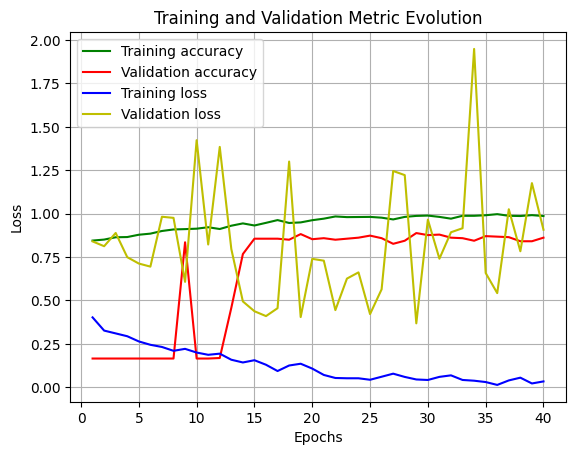

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')

plt.title('Training and Validation Metric Evolution')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

In [ ]:
import numpy as np

# Evaluate the model on the validation set
results = model.evaluate(valid_x_resized, valid_y_one_hot)

# Extract the accuracy from the results
accuracy = results[1]

# Predict classes for the validation set
valid_y_pred = model.predict(valid_x_resized)
valid_y_pred_classes = np.argmax(valid_y_pred, axis=1)

# Calculate precision and F1 score
tp = np.sum(np.argmax(valid_y_one_hot, axis=1) == valid_y_pred_classes)
fp = len(valid_y_pred_classes) - tp
fn = len(valid_y_pred_classes) - tp
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("F1 Score:", f1_score)

11/11 [==============================] - 14s 1s/step
Accuracy: 0.8613569140434265
Precision: 0.8613569321533924
F1 Score: 0.8613569321533924


In [ ]:
# Evaluate model on validation data
eval_results = model.evaluate(valid_x_resized, valid_y_one_hot)

# Make predictions on validation data
predictions = model.predict(valid_x_resized)
predicted_classes = np.argmax(predictions, axis=1)

# Calculate metrics
num_correct = np.sum(predicted_classes == np.argmax(valid_y_one_hot, axis=1))
accuracy = num_correct / valid_y_one_hot.shape[0]

true_positives = np.sum(np.logical_and(predicted_classes==1,
                                        np.argmax(valid_y_one_hot, axis=1)==1))
false_positives = np.sum(np.logical_and(predicted_classes==1,
                                        np.argmax(valid_y_one_hot, axis=1)!=1))
false_negatives = np.sum(np.logical_and(predicted_classes!=1,
                                        np.argmax(valid_y_one_hot, axis=1)==1))

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
f1 = 2 * (precision * recall) / (precision + recall)

# Print results
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))

11/11 [==============================] - 14s 1s/step
Accuracy: 0.8614
Precision: 0.8734
Recall: 0.9753
F1 Score: 0.9215


In [ ]:
from sklearn.metrics import accuracy_score

# Make predictions on validation data
predictions = model.predict(valid_x_resized)
predicted_classes = np.argmax(predictions, axis=1)

# Convert true labels to class indices
true_classes = np.argmax(valid_y_one_hot, axis=1)

# Calculate accuracy
accuracy = accuracy_score(true_classes, predicted_classes)

# Print accuracy
print("Accuracy:", accuracy)

11/11 [==============================] - 19s 2s/step
Accuracy: 0.8613569321533924


In [ ]:
false_negatives

7

In [ ]:
false_positives

40

In [ ]:
true_positives

276

In [ ]:
valid_x_resized

<tf.Tensor: shape=(339, 224, 224, 3), dtype=float32, numpy=
array([[[[0.7647059 , 0.72156864, 0.8       ],
         [0.7372549 , 0.69411767, 0.77254903],
         [0.7254902 , 0.68235296, 0.7607843 ],
         ...,
         [0.6509804 , 0.6313726 , 0.75686276],
         [0.6666667 , 0.63529414, 0.7647059 ],
         [0.6784314 , 0.627451  , 0.75686276]],

        [[0.77254903, 0.7294118 , 0.80784315],
         [0.77254903, 0.7294118 , 0.80784315],
         [0.7764706 , 0.73333335, 0.8117647 ],
         ...,
         [0.6039216 , 0.58431375, 0.70980394],
         [0.6313726 , 0.6       , 0.7294118 ],
         [0.6627451 , 0.60784316, 0.7411765 ]],

        [[0.78039217, 0.7372549 , 0.8156863 ],
         [0.7921569 , 0.7490196 , 0.827451  ],
         [0.8039216 , 0.7607843 , 0.8392157 ],
         ...,
         [0.58431375, 0.5686275 , 0.6901961 ],
         [0.6117647 , 0.58431375, 0.7058824 ],
         [0.6       , 0.5529412 , 0.6745098 ]],

        ...,

        [[0.972549  , 0.93333334

In [ ]:
model.save('mobilenet.h1')

In [ ]:
loss

In [ ]:
acc

In [ ]:
tf.keras.models.save_model(model, 'mobilenet.h5')

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('mobilenet.h1')

# Print the model's summary
loaded_model.summary()

# Get the model's weights
weights = loaded_model.get_weights()

# Print the weights
for layer_weights in weights:
    print(layer_weights)

Streaming output truncated to the last 5000 lines.
 -7.22368527e-03 -2.65181623e-02  8.22338238e-02  8.41228699e-04
  3.53757292e-02  1.02675206e-03 -1.93917304e-02 -4.16211113e-02
 -2.98783407e-02  7.00825918e-03  1.49957947e-02 -2.14458276e-02
  2.53719203e-02  6.31343052e-02  1.26472898e-02 -1.59216393e-02
 -3.07742730e-02 -2.76187416e-02  1.12597190e-04 -1.74906645e-02
  4.30301689e-02 -4.42379564e-02 -3.49432789e-02  1.25342505e-02
 -4.00524922e-02  2.07291935e-02 -5.02984505e-03  7.87450280e-03
  1.25290854e-02  1.82073545e-02  4.69315238e-03 -3.24209444e-02
  4.04349305e-02 -7.24562258e-03  1.33504253e-02  1.93670094e-02
 -1.95422899e-02  1.50260434e-03  9.42519959e-03  2.88749970e-02
  3.41486447e-02  1.11879306e-02  7.90062454e-03  1.38906660e-02
  9.40828025e-03 -1.98620241e-02 -3.55117768e-02  5.53284548e-02
 -1.81643758e-02  2.29513552e-02 -2.17929408e-02 -2.52910610e-03
 -8.12886506e-02  2.30986122e-02 -2.34412663e-02 -2.99916649e-03
 -3.64300772e-03 -3.16850990e-02 -6.013